In [ ]:
"""

We use the data and some of the code pipeline from DLS 2021 part2 homework 5 (Attention)

http://jalammar.github.io/illustrated-transformer/

Code for the transformer is from:
http://nlp.seas.harvard.edu/2018/04/03/attention.html

https://pytorch.org/tutorials/beginner/translation_transformer.html 

"""
None

In [1]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.9MB 6.9MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907055 sha256=a7c80dad5b3560faf2e1d7982f326068b1910c5b56f45ab940a3511a91218919
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5jlkidn/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
"""

Restart session after running the previous cell

"""
None

In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 958kB/s]


**Changing model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/DLS_nlp/

/content/drive/MyDrive/DLS_nlp


In [4]:
from torch import Tensor
import torch
import torch.nn as nn
import math

import numpy as np
from torch.autograd import Variable


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
# For reloading 


import project_part2 as modules
import imp
imp.reload(modules)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])

model = modules.make_model(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, 3, pruning=False)
model = model.to(DEVICE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

/content/drive/My Drive/DLS_nlp/project_part2.py:272: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


The model has 43,015,768 trainable parameters


In [6]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

BATCH_SIZE = 128

In [7]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [8]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
# def get_penalty(model):
#     loss = 0
#     count = 0
#     for name in model.state_dict():
#         if 'L0' in name:

#             import pdb
#             pdb.set_trace()
#             loss += model.state_dict()[name]
#             count += 1
#     return loss / count

# def loss_penalised(loss_bce, model, reg):
#     # import pdb
#     # pdb.set_trace()
#     return loss_bce + reg * get_penalty(model)

In [9]:
def get_penalty(model):
    
    loss = (model.encoder.layers[0].self_attn.L0 + model.encoder.layers[1].self_attn.L0 + 
            model.encoder.layers[2].self_attn.L0 + 
            model.decoder.layers[0].self_attn.L0 + model.decoder.layers[1].self_attn.L0 +
            model.decoder.layers[2].self_attn.L0 + 
            model.decoder.layers[0].src_attn.L0 + model.decoder.layers[1].src_attn.L0 +
            model.decoder.layers[2].src_attn.L0)

    return loss / 9

In [38]:
from torch.utils.data import DataLoader

reg = 0.01

def train_epoch(model, optimizer, pruned=False):
    model.train()
    losses = 0
    losses_translate = 0
    penalties = 0

    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
  
        src = src.transpose(0, 1)
        tgt_input = tgt_input.transpose(0, 1)

        src_mask = (src != PAD_IDX).unsqueeze(-2)
        tgt_mask = make_std_mask(tgt_input, PAD_IDX)

        logits = model(src, tgt_input, src_mask, tgt_mask)
        logits = model.generator(logits)
        logits = logits.transpose(0, 1)


        optimizer.zero_grad()

        tgt_out = tgt[1:, :]

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        if pruned:
            penalty = reg * get_penalty(model)
            loss_translate = loss.item()
            loss += penalty
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        if pruned:
            losses_translate += loss_translate
            penalties += penalty.item()
    
    if pruned:
        return losses / len(train_dataloader), losses_translate / len(train_dataloader), penalties / len(train_dataloader)

    return losses / len(train_dataloader)


def evaluate(model, pruned=False):
    model.eval()
    losses = 0
    losses_translate = 0
    penalties = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    with torch.no_grad():
        for src, tgt in val_dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            # tgt_input = tgt
            tgt_input = tgt[:-1, :]

            src = src.transpose(0, 1)
            tgt_input = tgt_input.transpose(0, 1)

            src_mask = (src != PAD_IDX).unsqueeze(-2)
            tgt_mask = make_std_mask(tgt_input, PAD_IDX)

            logits = model(src, tgt_input, src_mask, tgt_mask)
            logits = model.generator(logits)
            logits = logits.transpose(0, 1)

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

            if pruned:
                penalty = reg * get_penalty(model)
                loss_translate = loss.item()
                loss += penalty

                losses_translate += loss_translate
                penalties += penalty.item()

            losses += loss.item()

        if pruned:
            return losses / len(val_dataloader), losses_translate / len(val_dataloader), penalties / len(val_dataloader)

        return losses / len(val_dataloader)


In [12]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

prune = False

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, pruned=prune)
    end_time = timer()
    val_loss = evaluate(model, pruned=prune)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.246, Val loss: 4.064, Epoch time = 58.252s


KeyboardInterrupt: ignored

In [12]:
# torch.save(model.state_dict(), "model.pt")

In [13]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [15]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    c = 1

    memory = model.encode(src, src_mask)

    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)

        tgt_mask = torch.unsqueeze(tgt_mask, 0)

        out = model.decode(memory, src_mask, ys.transpose(0,1), tgt_mask)
        prob = model.generator(out)

        _, next_word = torch.max(prob[:,-1,:], dim=1)


        # if c > 1:
        #     import pdb
        #     pdb.set_trace()
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
        c+=1
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]

    src = src.transpose(0, 1)

    # src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    src_mask = (src != PAD_IDX).unsqueeze(-2)

    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

print(translate(model, "Eine Gruppe von Menschen steht vor einem Iglu ."))


 A group of people are in a of a of people . 


In [29]:
import project_part2 as modules
import imp
imp.reload(modules)


model = modules.make_model(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, 3, pruning=False)
model.load_state_dict(torch.load("model.pt", map_location=DEVICE),strict=False)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/content/drive/My Drive/DLS_nlp/project_part2.py:272: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [17]:
def collate_fn_test(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(token_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn_test)

In [18]:
from nltk.translate.bleu_score import corpus_bleu

from tqdm.notebook import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_dataloader)):

        src = batch[0]
        trg = batch[1]
        
        src = src.transpose(0, 1)

        for i in range(src.shape[0]):
            
            num_tokens = src[i,:].shape[0]

            src_t = src[i,:].unsqueeze(0)

            src_mask = (src_t != PAD_IDX).unsqueeze(-2)

            tgt_tokens = greedy_decode(
                model,  src_t, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
            
            translated_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))
            translated_tokens.remove('<bos>')

            if '<eos>' in translated_tokens:
                translated_tokens.remove('<eos>')
      
            generated_text.extend([translated_tokens])
        
        original_text.extend(trg)

In [19]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

21.174916355044402

In [41]:
import project_part2 as modules
import imp
imp.reload(modules)


model = modules.make_model(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, 3, pruning=True)
model.load_state_dict(torch.load("model.pt", map_location=DEVICE),strict=False)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/content/drive/My Drive/DLS_nlp/project_part2.py:272: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [42]:
for name in model.state_dict():
    if 'log_a' in name:
        print(model.state_dict()[name])


tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')
tensor([0.7206, 0.1326, 0.3579, 0.6536, 0.8184, 0.8401, 0.3193, 0.0190],
       device='cuda:0')


In [43]:
from timeit import default_timer as timer
NUM_EPOCHS = 90

train_losses = []
val_losses = []

train_losses_translate = []
train_penalties = []

val_losses_translate = []
val_penalties = []

prune = True
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss, train_loss_translate, train_penalty = train_epoch(model, optimizer, pruned=prune)
    train_losses.append(train_loss)

    train_losses_translate.append(train_loss_translate)
    train_penalties.append(train_penalty)

    end_time = timer()
    val_loss, val_loss_translate, val_penalty = evaluate(model, pruned=prune)
    val_losses.append(val_loss)

    val_losses_translate.append(val_loss_translate)
    val_penalties.append(val_penalty)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 4.608, Val loss: 5.509, Epoch time = 63.868s
Epoch: 2, Train loss: 4.499, Val loss: 5.399, Epoch time = 63.033s
Epoch: 3, Train loss: 4.418, Val loss: 5.370, Epoch time = 63.309s
Epoch: 4, Train loss: 4.360, Val loss: 5.356, Epoch time = 63.297s
Epoch: 5, Train loss: 4.294, Val loss: 5.359, Epoch time = 63.257s
Epoch: 6, Train loss: 4.236, Val loss: 5.339, Epoch time = 63.269s
Epoch: 7, Train loss: 4.186, Val loss: 5.326, Epoch time = 63.282s
Epoch: 8, Train loss: 4.133, Val loss: 5.334, Epoch time = 63.306s
Epoch: 9, Train loss: 4.074, Val loss: 5.312, Epoch time = 63.279s
Epoch: 10, Train loss: 4.024, Val loss: 5.271, Epoch time = 63.288s
Epoch: 11, Train loss: 3.979, Val loss: 5.251, Epoch time = 63.235s
Epoch: 12, Train loss: 3.937, Val loss: 5.236, Epoch time = 63.311s
Epoch: 13, Train loss: 3.890, Val loss: 5.248, Epoch time = 63.387s
Epoch: 14, Train loss: 3.848, Val loss: 5.245, Epoch time = 63.351s
Epoch: 15, Train loss: 3.804, Val loss: 5.225, Epoch time

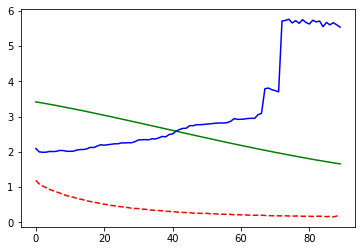

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses_translate, 'r--', val_penalties, 'g', val_losses_translate, 'b')
None

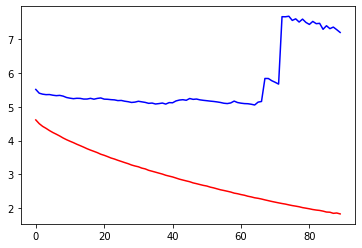

In [53]:
plt.plot(train_losses, 'r', val_losses, 'b')
None

In [54]:
# torch.save(model.state_dict(), "model_pruned_90.pt")

In [44]:
for name in model.state_dict():
    if 'log_a' in name:
        print(model.state_dict()[name])

tensor([-0.0334, -1.2038, -0.8065, -0.1983,  0.0482,  0.1967, -0.9881, -1.4020],
       device='cuda:0')
tensor([-0.9454, -1.7466, -1.5392, -1.0207, -0.9462, -0.8951, -1.5900, -1.9029],
       device='cuda:0')
tensor([-1.2554, -1.8477, -1.6532, -1.3355, -1.1373, -1.0605, -1.6709, -1.9874],
       device='cuda:0')
tensor([-0.4107, -1.4442, -0.7652, -0.1438,  0.1104,  0.1196, -0.9073, -1.5121],
       device='cuda:0')
tensor([-0.5924, -1.4552, -0.9806, -0.5946, -0.4510, -0.2014, -1.3279, -1.5340],
       device='cuda:0')
tensor([-0.8757, -1.7716, -1.4224, -1.0833, -0.8721, -0.8244, -1.5871, -1.8544],
       device='cuda:0')
tensor([-0.3429, -1.3657, -0.9457, -0.4358, -0.4621, -0.2145, -1.0099, -1.4980],
       device='cuda:0')
tensor([-1.1639, -1.8562, -1.6119, -1.2740, -1.1585, -1.0995, -1.6654, -1.9534],
       device='cuda:0')
tensor([-0.4979, -1.3234, -1.0439, -0.6012, -0.3707, -0.2270, -1.1492, -1.4815],
       device='cuda:0')


In [55]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss, train_loss_translate, train_penalty = train_epoch(model, optimizer, pruned=prune)
    train_losses.append(train_loss)

    train_losses_translate.append(train_loss_translate)
    train_penalties.append(train_penalty)

    end_time = timer()
    val_loss, val_loss_translate, val_penalty = evaluate(model, pruned=prune)
    val_losses.append(val_loss)

    val_losses_translate.append(val_loss_translate)
    val_penalties.append(val_penalty)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 1.811, Val loss: 7.094, Epoch time = 63.684s
Epoch: 2, Train loss: 1.791, Val loss: 7.220, Epoch time = 62.784s
Epoch: 3, Train loss: 1.779, Val loss: 7.135, Epoch time = 62.652s
Epoch: 4, Train loss: 1.755, Val loss: 7.091, Epoch time = 62.826s
Epoch: 5, Train loss: 1.743, Val loss: 7.173, Epoch time = 62.574s
Epoch: 6, Train loss: 1.727, Val loss: 7.094, Epoch time = 62.646s
Epoch: 7, Train loss: 1.718, Val loss: 7.013, Epoch time = 62.636s
Epoch: 8, Train loss: 1.703, Val loss: 7.058, Epoch time = 62.564s
Epoch: 9, Train loss: 1.672, Val loss: 7.094, Epoch time = 62.740s
Epoch: 10, Train loss: 1.659, Val loss: 7.067, Epoch time = 62.612s
Epoch: 11, Train loss: 1.660, Val loss: 7.049, Epoch time = 62.541s
Epoch: 12, Train loss: 1.650, Val loss: 7.047, Epoch time = 62.677s
Epoch: 13, Train loss: 1.618, Val loss: 7.027, Epoch time = 62.600s
Epoch: 14, Train loss: 1.608, Val loss: 6.987, Epoch time = 62.619s
Epoch: 15, Train loss: 1.601, Val loss: 6.987, Epoch time